In [1]:
import pandas as pd
import os
import numpy as np
import logging
import sys
import torch
import copy
import yaml
import random

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from skmisc.loess import loess
from sklearn.metrics import log_loss, brier_score_loss


#sns.set_style("white")
sns.set_style("ticks")
custom_palette = ["red", "green", "orange", "blue"]
sns.set_palette(custom_palette)
grp_label_dict = {1: 'Black women', 2: 'White women', 3: 'Black men', 4: 'White men'}    
from prediction_utils.pytorch_utils.metrics import CalibrationEvaluator, BinningEstimator

#EXPERIMENT_NAME = 'mon_grid_regularized_tuning'
#EXPERIMENT_NAME = 'big_test_mmd_tuning'
EXPERIMENT_NAME = 'big_test_regularized_tuning'
#EXPERIMENT_NAME = 'big_test_erm_tuning'

num_configs=9

BASE_PATH = '/labs/shahlab/projects/agataf/data/cohorts/pooled_cohorts'
args = {'experiment_name': EXPERIMENT_NAME,
        'cohort_path': '/labs/shahlab/projects/agataf/data/pooled_cohorts/cohort_extraction/all_cohorts_0.2test.csv',
        'base_path': BASE_PATH
       }

output_path = '/labs/shahlab/projects/agataf/fairness_utility/eval/plots'
os.makedirs(output_path, exist_ok=True)
experiment_plot_path=os.path.join(output_path, EXPERIMENT_NAME)
os.makedirs(experiment_plot_path, exist_ok=True)
aggregate_path = os.path.join(args['base_path'], 'experiments', args['experiment_name'], 'performance', 'all')
os.makedirs(aggregate_path, exist_ok=True)

data_path="/labs/shahlab/projects/agataf/data/pooled_cohorts/cohort_extraction"


In [2]:
args = {'experiment_name': EXPERIMENT_NAME,
        'cohort_path': '/labs/shahlab/projects/agataf/data/pooled_cohorts/cohort_extraction/all_cohorts_0.2test.csv',
        'base_path': BASE_PATH
       }
cohort = pd.read_csv(args['cohort_path'])
fold_dict = cohort.set_index('person_id').fold_id.to_dict()



### get results

In [3]:
standard_eval = []
outputs=[]
for config_id in range(num_configs):
    for fold_id in range(1,11):
        RESULT_PATH = os.path.join(args['base_path'], 'experiments', args['experiment_name'], 'performance',
                                           '.'.join((str(config_id), 'yaml')), str(fold_id))
        LOGGING_PATH = os.path.join(RESULT_PATH, 'training_log.log')
        
        CONFIG_PATH = os.path.join(args['base_path'], 'experiments', args['experiment_name'], 'config',
                                                   '.'.join((str(config_id), 'yaml')))


        config = yaml.load(open(CONFIG_PATH), Loader=yaml.SafeLoader)
        if config.get('lambda_group_regularization') is not None:
            lambda_reg = config.get('lambda_group_regularization')
        else:
            lambda_reg=0

        result_df_group_standard_eval = (pd.read_parquet(
            os.path.join(RESULT_PATH,
                         'result_df_group_standard_eval.parquet'
                        ))
                                         .assign(fold_id=fold_id,
                                                 config_id=config_id,
                                                 lambda_reg=lambda_reg))
        standard_eval.append(result_df_group_standard_eval)
        
        output_df = (
            pd.read_parquet(
                os.path.join(RESULT_PATH,
                             'output_df.parquet'
                            )
            )
            .assign(fold_id=fold_id,
                    config_id=config_id,
                    lambda_reg=lambda_reg)
        )
        
        outputs.append(output_df)

df = pd.concat(standard_eval)
preds = pd.concat(outputs)

# (TODO): get rid of this hack by splitting into test and eval early on
preds = preds.assign(phase = lambda x: np.where(x.phase =='test',
                                         x.person_id.map(fold_dict),
                                         x.phase)
                    )

df.to_csv(os.path.join(aggregate_path, 'standard_evaluation.csv'), index=False)
preds.to_csv(os.path.join(aggregate_path, 'predictions.csv'), index=False)

In [4]:
def plot(df, zoom=False, output_path=None):
    g = sns.relplot(data = df,
                    x = 'pred_probs',
                    y = 'calibration_density',
                    row = 'is_white',
                    col = 'is_male',
                    kind = 'line',
                    hue = 'lambda_reg',
                    facet_kws = {'sharey': True, 'sharex': True},# 'margin_titles': True},
                    legend = True,
                    aspect = 1.2)
    axes = g.axes.flatten()

    grp_label_dict = {1: 'Black women', 2: 'White women', 3: 'Black men', 4: 'White men'}    

    for i, ax in enumerate(axes):
        ax.axline(xy1 = (0,0), slope = 1, color = "b", dashes = (5, 2), label = "Perfectly calibrated")
        ax.axvline(x = 0.075, linestyle = '--', color = 'grey')
        ax.axvline(x = 0.2,   linestyle = '--', color = 'grey')
        ax.axhline(y = 0.075, linestyle = '--', color = 'grey')
        ax.axhline(y = 0.2,   linestyle = '--', color = 'grey')
        ax.set_title(grp_label_dict[i+1])
        if zoom:
            ax.set(xlim = (0, 0.25), ylim = (0, 0.25))
        else:
            ax.set(xlim = (0, 1), ylim = (0, 1))
        if i > 1:
            ax.set_xlabel("predicted risk")
        if ((i % 2) == 0):
            ax.set_ylabel("fraction of positives")
    if output_path is not None:
        g.savefig(output_path)

## use calibration evaluator, aggregate across folds

In [25]:
def calib_performance(model, x, y, sample_weight=None, transform=None):
    x = x.values.reshape(-1, 1)
    y = y.values.reshape(-1, 1)
    if transform=='log':
        x = np.log(x)
    
    y_preds = model.predict_proba(x)[:,-1]
    
    brier = brier_score_loss(y_true = y,
                       y_prob = y_preds,
                       sample_weight=sample_weight)

    logloss = log_loss(y_true = y,
                       y_pred = y_preds,
                       sample_weight=sample_weight
                      )
    
    results = pd.DataFrame.from_dict({'metric': ['brier', 'logloss'],
                 'value': [brier, logloss],
                 })

    return results


def get_calib_probs(model, x, transform=None):
    
    if transform=='log':
        model_input = np.log(x)
    else:
        model_input = x
        
    calibration_density = model.predict_proba(model_input.reshape(-1, 1))[:, -1]
                    
    df = pd.DataFrame({'pred_probs': x,
                       'model_input': model_input,
                       'calibration_density': calibration_density})  
    return df
    
def get_calib_model(preds_test, transform=None):
    
    evaluator = CalibrationEvaluator()
    _, model = evaluator.get_calibration_density_df(preds_test.labels,
                                                     preds_test.pred_probs,
                                                     preds_test.weights,
                                                     transform = transform)

    return model


def calc_calibration(preds, num_configs, transform=None):
    calib_lin = []
    calib_test = []
    fits=[]
    for config_id in range(num_configs):
        for group in range(1,5):
            max_pred_prob = (preds.query("(phase=='eval') \
                                        & (config_id==@config_id) \
                                        & (group==@group)"
                                        )
                             .pred_probs
                             .max()
                            )
            for fold_id in range(1,11):
                preds_eval = preds.query("(phase=='eval') \
                                        & (config_id==@config_id) \
                                        & (group==@group) \
                                        & (fold_id==@fold_id)"
                                        )
                preds_test = preds.query("(phase=='test') \
                                        & (config_id==@config_id) \
                                        & (group==@group) \
                                        & (fold_id==@fold_id)"
                                        )
                lambda_reg = preds_eval.lambda_reg.unique()[0]
                model_params = {'fold_id': fold_id,
                                'config_id': config_id,
                                'group': group,
                                'lambda_reg': str(round(lambda_reg, 3))}
                
                model = get_calib_model(preds_eval, transform)
                
                
                performance = (calib_performance(model,
                                                 x = preds_eval.pred_probs,
                                                 y = preds_eval.labels, 
                                                 sample_weight = preds_eval.weights,
                                                 transform = transform)
                               .assign(**model_params)
                              )
    
                synth_calib = (get_calib_probs(model, 
                                              np.linspace(1e-15, max_pred_prob, 30), 
                                              transform) 
                               .assign(**model_params)
                              )
            
                test_calib = (get_calib_probs(model, 
                                             preds_test.pred_probs.values, 
                                             transform)  
                              .assign(**model_params)
                             )
                
                
                fits.append(performance)
                
                calib_lin.append(synth_calib)
                
                calib_test.append(test_calib)


    calibrations_lin = (pd
                       .concat(calib_lin)
                       .assign(is_male = lambda x: np.where((x.group == 3) | (x.group == 4), 1, 0),
                               is_white = lambda x: np.where((x.group == 2) | (x.group == 4), 1, 0)
                              )
                      )

    calibrations_test = (pd
                       .concat(calib_test)
                       .assign(is_male = lambda x: np.where((x.group == 3) | (x.group == 4), 1, 0),
                               is_white = lambda x: np.where((x.group == 2) | (x.group == 4), 1, 0)
                              )
                      )

    eval_df = (pd
                       .concat(fits)
                       .assign(is_male = lambda x: np.where((x.group == 3) | (x.group == 4), 1, 0),
                               is_white = lambda x: np.where((x.group == 2) | (x.group == 4), 1, 0)
                              )
                      )
    
#     fits_df = pd.DataFrame(fits).assign(is_male = lambda x: np.where((x.group == 3) | (x.group == 4), 1, 0),
#                                         is_white = lambda x: np.where((x.group == 2) | (x.group == 4), 1, 0)
#                                        )
    
    return calibrations_lin, calibrations_test, eval_df

## use log transform

In [26]:
calibrations_lin, calibrations_test, fits_df = calc_calibration(preds, num_configs, transform='log')

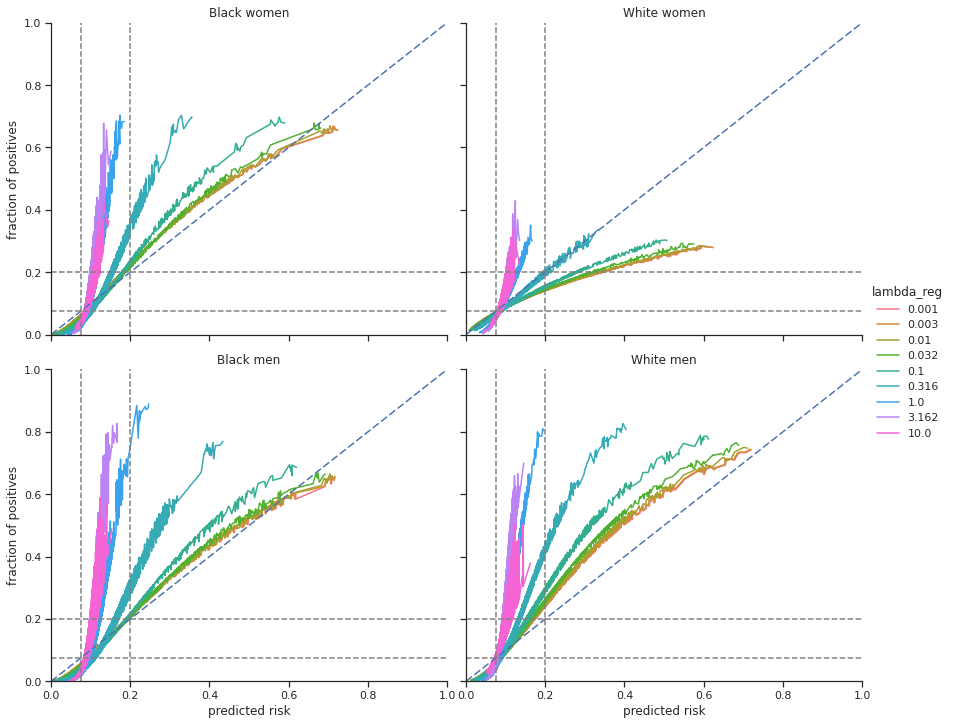

In [24]:
plot(calibrations_test, 
     output_path = os.path.join(experiment_plot_path, 'logreg_logx.png')
    )

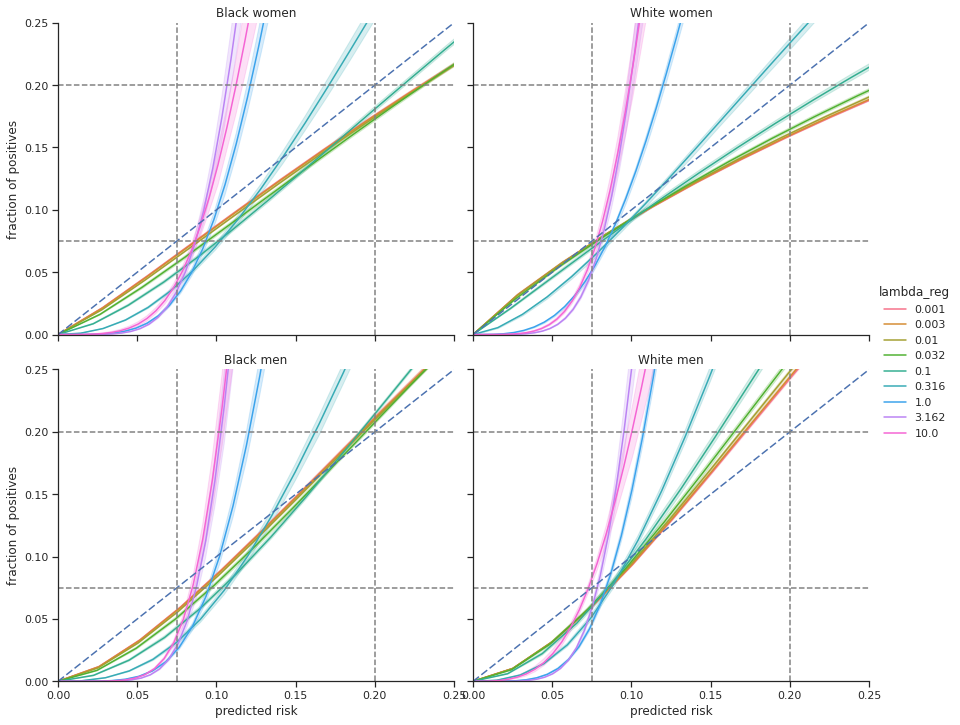

In [33]:
plot(calibrations_df_logx, 
     zoom=True,
     output_path = os.path.join(experiment_plot_path, 'logreg_logx_zoom.png')
    )

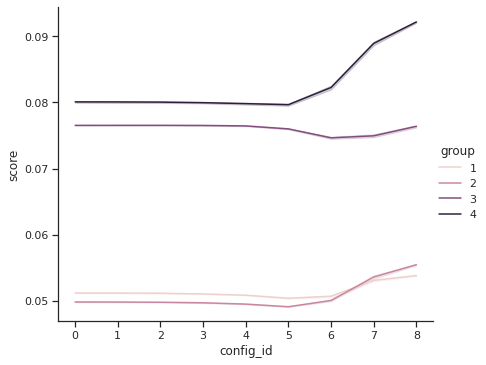

In [18]:
sns.relplot(data = fits_logreg,
            x = 'config_id',
            y = 'score',
            kind = 'line',
            hue = 'group',
            facet_kws = {'sharey': True, 'sharex': True},
            legend = True,
            aspect = 1.2)

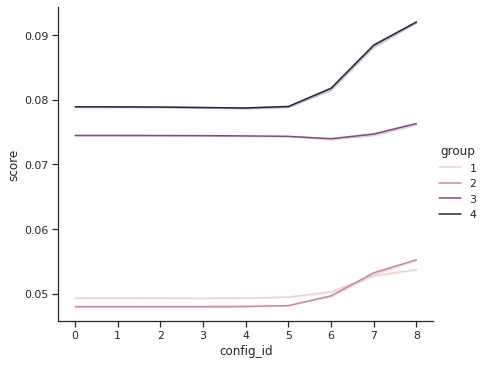

In [19]:
sns.relplot(data = fits_df_logx,
            x = 'config_id',
            y = 'score',
            kind = 'line',
            hue = 'group',
            facet_kws = {'sharey': True, 'sharex': True},
            legend = True,
            aspect = 1.2)

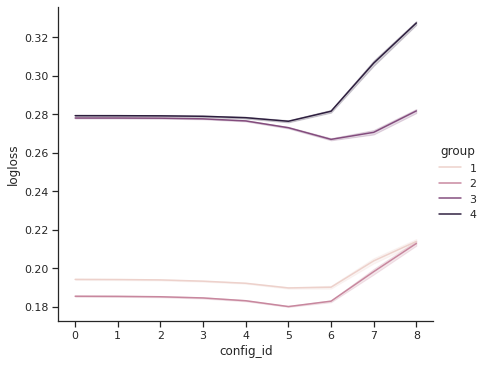

In [20]:
sns.relplot(data = fits_logreg,
            x = 'config_id',
            y = 'logloss',
            kind = 'line',
            hue = 'group',
            facet_kws = {'sharey': True, 'sharex': True},
            legend = True,
            aspect = 1.2)